# Final Project Report: Movie Revenue Classification
# Pankaj Ajit
# pajit@andrew.cmu.edu

### INTRODUCTION

#### An introduction that explains what prediction problem you have selected </br>

I've chosen the movie revenue dataset provided in the course. I'm going to predict whether a movie will be successful based on its pre-release reviews. I define successful movie as any movie that makes over 10 million dollars at the box office. Therefore this becomes a text classification (supervised) problem. 

#### What is interesting and important about it

There are many films produced in a year but only a few of those are succesful. The uncertainty in audience tastes leads us to interesting aspects of the problem-
1. Making a movie requires a signigicant investment of time and effort. The least investors expect is to make their money back. Based on the prediction of this model, investors can make a decision whether to green light this movie or not. This will reduce the risk of investment.
2. Many productoin houses play it safe and not give chances to upcoming writers with great scripts. You often hear stories of scripts that were turned down for many years before they were made and went on to be hits. The predictions from this project may allow investors to take more chances on good scripts regardless of whether the person is new to the industry.
I decided to focus more on the second point. Which means that for me, from an artistic point of view, I want more of the good scripts to be made into movies. So I care about maximizing my true positives.


#### Prior work
1. [1] Predicting box-office success of motion pictures with neural networks, Shrada et al. https://www.sciencedirect.com/science/article/pii/S0957417405001399
They found that neural networks performed better compared to logistic regression. I got the idea to turn this into a classification problem from them. They had converted the revenue into 9 classes, however, I relaxed the class constraints and turned into a binary classification problem. They also had some interesting category features - genre,sequel, MPAA rating.

2.  [2]“Predicting Movie Box Office Gross” by Jason van der Merwe et al. http://www.jasonvandermerwe.com/pdf/antevorta.pdf
They used Logistic regression as their method. I will adopt this as my baseline. They also had some interesting ways to reduce the feature space like excluding actor names in the data who only acted in 1 film. This helped them reduce the dimensionality and sped up their algorithms. I think I will adopt a similar approach and remove all nouns that occured only once. They also used features like MPAA ratings

3. [3] "Feature selection, l1 vs l2 regularization, and rotational invariance" https://pdfs.semanticscholar.org/8650/a37500346c52cae22f9180af67a50c715f89.pdf by Andrew Ng. It talks about L1 as a good way of performing regularization.


#### Describes at a high level the ideas you applied as you were working on your project.  
At a high level these are the steps that I performed-
1. Data Exploration, cleaning, and making 2 classes from the revenue
2. Creating feature representation of text by using unigram word counts
3. Building a baseline logistic regression model on it
4. Defining accuracy in terms of "accuracy" and also evaluating it by looking at the confusion matrix for true positive rates. I care more about predicting success.
5. Iteratively performing error analysis and improving features 
6. Tuning and configuring logistic regression, trying other models.




### DESCRIPTION OF THE DATA AND SET UP

#### Start by describing what raw features were given to you
The movie revenue data set was given to me. There were 3 data sets in total - train, dev and test set.
It was already partitioned and I didn't have to create these 3 sets on my own. 
Each set comprised of 1 feautre consisting of text and the other the revenue made by the movie at the box office. The text was the review of the movie during pre-release. The revenue was numeric.

#### What you did to turn it into a tabular form that could be input to a machine learning algorithm.  
The data was already in csv format.

#### How you cleaned the data if necessary  
I searched for missing values in the revenue column and foud none. 
No other cleaning was done in the initial stages.

#### Initial feature space representation
I created count vectors for the text so that it could be read by the logistic regression algorithm.
Explanation: The entire vocabulary of words is created as feature headers. The count of each word in a data point will be the feature value against the feature headers for that data point.


#### You should also discuss what you decided would be your class value  
I made histograms of the revenue. Based on the histogram for revenue, I think that movies making more than 10 million can be called box office success. I did not want to set a stricter (higher value) because then the classes become too imbalanced and dealing with class imbalance becomes yet another challenge. Anything over 10 million was labelled with a class of 1, anything less was labelled with a class of 0

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


train = pd.read_csv('7domains-train.csv')
dev =  pd.read_csv('7domains-dev.csv')
test = pd.read_csv('7domains-test.csv')

train.head(10)

,text,class
0,"Giovanni Ribisi, with pasty skin and hair slic...",20774.0
1,“13 Tzameti” flaunts a grim sense of the absu...,10805.0
2,Based on a Stephen King short story that bears...,20617667.0
3,iven the number of films that have featured as...,818.0
4,Richard Donner still has it. 16 Blocksmay be a...,11855260.0
5,A serial lover meditates on longing a...,113074.0
6,The sword-and-sandals genre is one of the few ...,70885301.0
7,There's nothing in the vampire epic 30 Days of...,15951902.0
8,Westerns and remakes are two film categories w...,14035033.0
9,This world-famous British series is one of the...,120207.0


In [2]:
print (train.shape)
print (dev.shape)
print (test.shape)

(1147, 2)
(317, 2)
(254, 2)


In the above cell you see the number of data points  in each file. <br/>
In the code below, I'm exploring the revenue to decide what I should set as my classes.

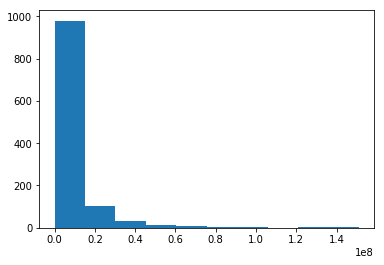

In [3]:
from matplotlib import pyplot as plt
plt.hist(train['class'])
plt.show()

##### Decision on class values:
Based on the code histogram for class (revenue), I think that movies making more than 10 million can be called box office success. I did not want to set a stricter (higher value) because then the classes become too imbalanced and dealing with that becomes harder. 

In [4]:
def f(row):
    if row['class'] > 10000000:
        val =1
    else:
        val = 0
    return val

train['Label'] = train.apply(f, axis=1)
dev['Label'] = train.apply(f, axis=1)
test['Label'] = train.apply(f, axis=1)
train.shape

(1147, 3)

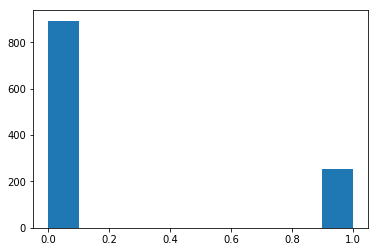

In [5]:
plt.hist(train['Label'])
plt.show()

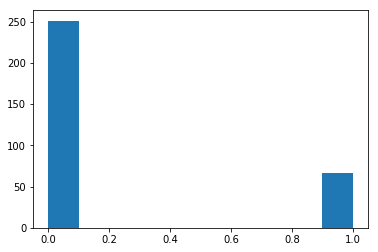

In [6]:
plt.hist(dev['Label'])
plt.show()

##### Count vectors for feature space representation
Before a baseline model is created I have to figure out a way to get represent features from text. I will tokenize the words and get the count of each word in the vocabulary in each data point. This ignores word order but it will help me get to a baseline model.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train.text)
X_dev_counts = count_vect.transform(dev.text)
X_test_counts = count_vect.transform(test.text)
X_train_counts.shape

(1147, 68844)

### BASELINE and ERROR ANALYSIS

#### A description of your baseline experiment
Similar to paper [2] I chose logistic regression for my baseline model.  F(z) = 1/(1+e^-z).<br/>
I did 5 fold cross validation on the train set maintaining default settings for the hyperparameters on the logistic model.
I chose accuracy for evaluating my model (fraction of correct predictions) when evaluating my cross valdation.
After cross validation, I tested the model on the dev set to check for overfitting/underfitting. I want to generalize over unseen data. Additionally, I also computed the kappa score as compared to a majority classifier. Here the majority classifier will predict 0 for all classes.


#### One interesting error analysis 
I submitted 4 error analysis in total which were done in light side. I did many more.
The basic procedure was to look at horizontal and vertical absolute differences along with feature weights
for misclassified positives. To name a few- I did stop word removal, bigrams, word embeddings using word2vec, tf idf etc. None of these had a significant impact on the performance.

Here I will describe 1 more interesting error analysis

#### problematic features you identified 
According to the paper [1] the movie reviews are rated as MPAA: R for adult rated audiences. 
Similarly there are other movie ratings. But when I'm performing word vectorization there are a few problems
1. It doesn't capture 3 word combinations like this
2. 'A' could be interpreted as "A house on the road" instead of as part of the rating. 
Here's my hypothesis - I think that movie ratings are important for deciding the amount of money it will make.  For example, an adult rated movie with strong sexual content may not make as much money as a family friendly movie.

#### what ideas you had for improvement
My idea is to capture all MCAA ratings as new features
1. MPAA rating: G
2. MPAA rating: R
3. MPAA rating: Unrated
4. MPAA rating:PG
5. MPAA rating: NC


#### an evaluation of whether it worked.
There no significant improvement. I got the same accuracy as before. A possible reason could be that there simply are enough people who watch each genre. On further research I found papers claiming that either MPAA worked or that MPAA was not a significant feature.

##### Building logistic regression for baseline

In [8]:
import numpy as np
import sklearn
from sklearn import linear_model
clf = linear_model.LogisticRegression()
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, cohen_kappa_score
mj_clf_train = train.shape[0]* [0]
mj_clf_dev = dev.shape[0]* [0]
mj_clf_test = test.shape[0]* [0]
scores = cross_validate(clf, X_train_counts, train.Label, scoring='accuracy',cv=5, return_train_score=False)
print ("the accuracy of each fold of prediction is")
summer = 0
for score in scores['test_score']:
    summer+=score
    print (score)
print ("The average accuracy is", summer/5)

the accuracy of each fold of prediction is
0.821739130435
0.847826086957
0.8
0.847161572052
0.859649122807
The average accuracy is 0.83527518245


##### Dev set prediction and Confusion matrix  

In [9]:
clf.fit(X_train_counts,train.Label)
dev_label_predicted = clf.predict(X_dev_counts)
print ("dev accuracy is ",np.mean(dev_label_predicted == dev.Label))
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_true =dev.Label,y_pred =dev_label_predicted,).ravel()
print (sklearn.metrics.confusion_matrix(dev_label_predicted, dev.Label))
print ("True positive rate is", (tp)/(tp+fn))

dev accuracy is  0.665615141956
[[198  53]
 [ 53  13]]
True positive rate is 0.19696969697


The dev set has poor performance.<br/> 
This shows that my model is overfitting the training set. <br/> 
Looking at the confusion matrix. <br/> 
I also see most of the positives are incorrectly classified as negatives.<br/> 

##### Error Analysis for MPAA ratings

In [10]:
temp= train[train['text'].str.contains("MPAA rating:G|MPAA rating: G")]
temp['G_Rating'] = 1
temp = temp[['G_Rating']]
train = train.join(temp)

temp= train[train['text'].str.contains("MPAA rating:R|MPAA rating: R")]
temp['R_Rating'] = 1
temp = temp[['R_Rating']]
train = train.join(temp)

temp= train[train['text'].str.contains("MPAA rating:PG|MPAA rating: PG")]
temp['PG_Rating'] = 1
temp = temp[['PG_Rating']]
train = train.join(temp)

temp= train[train['text'].str.contains("MPAA rating:NC|MPAA rating: NC")]
temp['NC_Rating'] = 1
temp = temp[['NC_Rating']]
train = train.join(temp)

temp= train[train['text'].str.contains("MPAA rating:Unrated|MPAA rating: Unrated")]
temp['Un_Rating'] = 1
temp = temp[['Un_Rating']]
train = train.join(temp)

temp= dev[dev['text'].str.contains("MPAA rating:G|MPAA rating: G")]
temp['G_Rating'] = 1
temp = temp[['G_Rating']]
dev = dev.join(temp)

temp= dev[dev['text'].str.contains("MPAA rating:R|MPAA rating: R")]
temp['R_Rating'] = 1
temp = temp[['R_Rating']]
dev = dev.join(temp)

temp= dev[dev['text'].str.contains("MPAA rating:PG|MPAA rating: PG")]
temp['PG_Rating'] = 1
temp = temp[['PG_Rating']]
dev = dev.join(temp)

temp= dev[dev['text'].str.contains("MPAA rating:NC|MPAA rating: NC")]
temp['NC_Rating'] = 1
temp = temp[['NC_Rating']]
dev = dev.join(temp)

temp= dev[dev['text'].str.contains("MPAA rating:Unrated|MPAA rating: Unrated")]
temp['Un_Rating'] = 1
temp = temp[['Un_Rating']]
dev = dev.join(temp)

temp= test[test['text'].str.contains("MPAA rating:G|MPAA rating: G")]
temp['G_Rating'] = 1
temp = temp[['G_Rating']]
test = test.join(temp)

temp= test[test['text'].str.contains("MPAA rating:R|MPAA rating: R")]
temp['R_Rating'] = 1
temp = temp[['R_Rating']]
test = test.join(temp)

temp= test[test['text'].str.contains("MPAA rating:PG|MPAA rating: PG")]
temp['PG_Rating'] = 1
temp = temp[['PG_Rating']]
test = test.join(temp)

temp= test[test['text'].str.contains("MPAA rating:NC|MPAA rating: NC")]
temp['NC_Rating'] = 1
temp = temp[['NC_Rating']]
test = test.join(temp)

temp= test[test['text'].str.contains("MPAA rating:Unrated|MPAA rating: Unrated")]
temp['Un_Rating'] = 1
temp = temp[['Un_Rating']]
test = test.join(temp)

train.fillna(0, inplace=True)
dev.fillna(0, inplace=True)
test.fillna(0, inplace=True)
train.head(10)

train_ft = train[['G_Rating','R_Rating','PG_Rating','NC_Rating','Un_Rating']]
dev_ft = dev[['G_Rating','R_Rating','PG_Rating','NC_Rating','Un_Rating']]
test_ft = test[['G_Rating','R_Rating','PG_Rating','NC_Rating','Un_Rating']]
X_train_counts = pd.DataFrame(X_train_counts.todense(), columns=count_vect.get_feature_names())
X_train_counts = X_train_counts.join(train_ft)
X_dev_counts = pd.DataFrame(X_dev_counts.todense(), columns=count_vect.get_feature_names())
X_dev_counts = X_dev_counts.join(dev_ft)
X_test_counts = pd.DataFrame(X_test_counts.todense(), columns=count_vect.get_feature_names())
X_test_counts = X_test_counts.join(test_ft)

clf = linear_model.LogisticRegression()
scores = cross_validate(clf, X_train_counts, train.Label, scoring='accuracy',cv=5, return_train_score=False)
print ("the accuracy of each fold of prediction is")
summer = 0
for score in scores['test_score']:
    summer+=score
    print (score)
print ("The average accuracy on train is", summer/5)
clf.fit(X_train_counts,train.Label)
dev_label_predicted = clf.predict(X_dev_counts)
print ("dev accuracy is ",np.mean(dev_label_predicted == dev.Label))
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_true =dev.Label,y_pred =dev_label_predicted,).ravel()
print (sklearn.metrics.confusion_matrix(dev_label_predicted, dev.Label))
print ("True positive rate is", (tp)/(tp+fn))

the accuracy of each fold of prediction is
0.821739130435
0.847826086957
0.8
0.847161572052
0.859649122807
The average accuracy on train is 0.83527518245
dev accuracy is  0.668769716088
[[198  52]
 [ 53  14]]
True positive rate is 0.212121212121


### TUNING

I observed that my model was over-fitting the data. Given this I decided to introduce regularizatoin to control it.
There were a few choices of regularization that I considered -
1. L1 regularization which uses the L1 norm 
2. L2 regularizatoin which uses the L2 norm

One important consideration that I had is that my data was incredibly sparse.
In paper [3] I read about the benefits of choosing L1 over L2. Therefore I'm choosing L1.

In the Sklearn logistic regression model the value to tune is C. <br/>
The smaller the C value, the stronger the regularization. <br/>
The default value is 1.<br/>
I decided to tune by trying out many orders of 10ths lower each time of C <br/>

Each time I change C value, I add a plot point of training error and development error.
I made the plot on a negative log scale (base 10) so that it is more interpretable.
I found a stabilization of train and dev error in the plots near the -log scale 4 mark.
However, what I noticed is that my true positive rate becomes very poor at this mark. So prioritizing my importance of getting more true positives, I decided to use C = 0.1 <br/>

There was no significant improvement on the dev set with repect to the baseline.

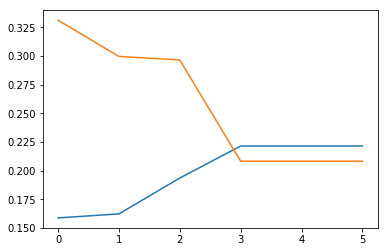

In [11]:
C_values = [1,0.1,0.01,0.001,0.0001,0.00001]
#C_values = list(reversed(C_values))
train_error = list()
dev_error = list()

for c_val in C_values:
    clf = linear_model.LogisticRegression(penalty='l1', C = c_val)
    scores = cross_validate(clf, X_train_counts, train.Label, scoring='accuracy',cv=5, return_train_score=False)
    summer = 0
    for score in scores['test_score']:
        summer+=score
    train_error.append(summer/5)
    clf.fit(X_train_counts,train.Label)
    dev_label_predicted = clf.predict(X_dev_counts)
    dev_error.append(np.mean(dev_label_predicted == dev.Label))

for i in range(0,len(C_values),1):
    train_error[i] = 1-train_error[i]
    dev_error[i] = 1-dev_error[i] 

C_values = [0,1,2,3,4,5]
plt.plot(C_values, train_error, C_values, dev_error)
plt.show()

In [12]:
clf = linear_model.LogisticRegression(penalty='l1', C =  0.1)
scores = cross_validate(clf, X_train_counts, train.Label, scoring='accuracy',cv=5, return_train_score=False)
print ("the accuracy of each fold of prediction is")
summer = 0
for score in scores['test_score']:
    summer+=score
    print (score)
print ("The average accuracy in train set is", summer/5)
clf.fit(X_train_counts,train.Label)
dev_label_predicted = clf.predict(X_dev_counts)
print ("dev accuracy is ",np.mean(dev_label_predicted == dev.Label))
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_true =dev.Label,y_pred =dev_label_predicted,).ravel()
print (sklearn.metrics.confusion_matrix(dev_label_predicted, dev.Label))
print ("True positive rate is", (tp)/(tp+fn))

the accuracy of each fold of prediction is
0.84347826087
0.834782608696
0.839130434783
0.855895196507
0.815789473684
The average accuracy in train set is 0.837815194908
dev accuracy is  0.700315457413
[[209  53]
 [ 42  13]]
True positive rate is 0.19696969697


### TEST SET EVALUATION

I observe that the test set performance is close to the dev set performance.

In [13]:
test_label_predicted = clf.predict(X_test_counts)
print ("test accuracy is ",np.mean(test_label_predicted == test.Label))
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_true = test.Label,y_pred =test_label_predicted,).ravel()
print (sklearn.metrics.confusion_matrix(test_label_predicted, test.Label))
print ("True positive rate is", (tp)/(tp+fn))

test accuracy is  0.661417322835
[[157  47]
 [ 39  11]]
True positive rate is 0.189655172414


### DISCUSSION OF WHAT I LEARNED

I learned about the following by doing this project-
1. I learned that what we care about is generalizing on our data making sure that we don't just overfit a training set. We want to be able to predict accurately on unseen data. 
2. I also learned about improving features through an error analysis. In doing this project I tried a few ways but failed. But reading more I see many more interesting and possible ways of extracting meaningful information from text.
3. Through the error analysis I learned that machine learning isnt' as black box as I had thought. By going through the data and studying the domain you can build better models.
4. The whole process is iterative. And not to be all philosophical but- When you make a decision either the algorithm learns and if it doesn't then you learn.
5. I also found that it is very hard to not lose the semantic meaning in text while getting feature representations from text. In this process I explored- word embeddings like word2vec and doc2vec. Even though I couldn't get it working as I wanted to, I still hope to use these in the future.
6. Dealing with class imbalance is very hard and I have to explore explicit methods that target such situations. I read about over sampling techniques but haven't implemented it here.

##### Thanks for the class Carolyn and Sree ! 